<a href="https://colab.research.google.com/github/ktichola/Image-matching/blob/main/IMC2024_Enhancing_Performance_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-matching-challenge-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F71885%2F8143495%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T111355Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db2b9f51a2bec93c59d590a8f1e8de1df5de4390ff00bc1104e8d9dd3f9c37f29ad63d2b61ca6ffb35845903f6803d5ad37a77fdf27d02c1fe69ff65847e23e66fb10a2a5dca1d762fd8e1ac6c17bb2c9a05fd605e8d12c5cdc697af018beb5ee86a4dd2e41ec73e7a04113d3d9c8c77eb38bf2509f28a2d479e9867be6c3e4c9c5f24ff66a9caa3d99155829711c8a3be00107a5b916850ad52a83429b1a3b8b9b4cc773494260eb0879e44bf837c19ee1174068f710af64e182d741430060573c1ad12ea266fd6d46a46e08013e0e256ce5ccf99b9678522dd1cfef6e4e603853987de4bca3d1f938f50285f3b7b592b518ecee501517d7596ae6ebf69e556f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# **Image Matching Challenge 2024 - Hexathlon**

## **Notebook Published by:** Aarish Asif Khan

## **Date:** 20th April 2024

---

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

import os
import pandas as pd

from matplotlib import pyplot as plt
import time

2024-05-14 11:13:10.701068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 11:13:10.701192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 11:13:10.838270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Defining Constants
Image_size = (128, 128)

Img_width = 128
Img_height = 128

batch_size = 32
epochs = 15
channels = 3

# Define image dimensions
num_classes = 7

In [ ]:
# Load the datasets
# 1. sample_submission.csv
sample_submission = pd.read_csv("/kaggle/input/image-matching-challenge-2024/sample_submission.csv")
sample_submission.head()

,image_path,dataset,scene,rotation_matrix,translation_vector
0,test/church/images/00046.png,church,church,0.9711190310868889;0.8911359604510818;0.532623...,0.11313904678659892;0.8432251602872274;0.42609...
1,test/church/images/00090.png,church,church,0.20360069697426775;0.6504946118853364;0.86491...,0.680480221630539;0.8028143635199276;0.5028546...
2,test/church/images/00092.png,church,church,0.831738872848693;0.5821652805589269;0.6032012...,0.16253346680799086;0.2541505473736173;0.87383...
3,test/church/images/00087.png,church,church,0.1604600521094205;0.6489370807852337;0.721831...,0.2161246142041484;0.9530634517785977;0.449099...
4,test/church/images/00050.png,church,church,0.38660496248295817;0.4015767283826711;0.92385...,0.16786019693458032;0.8533039000844846;0.96215...


In [ ]:
# 2. train_labels.csv
train_labels = pd.read_csv("/kaggle/input/image-matching-challenge-2024/train/train_labels.csv")
train_labels.head()

,image_name,rotation_matrix,translation_vector,calibration_matrix,dataset,scene
0,00.png,0.999017467386748;-0.01951432487219089;0.03979...,-0.011700149127917355;0.018812528601332625;0.3...,5809.066058292364;0.0;2496.9582994472266;0.0;5...,transp_obj_glass_cup,transp_obj_glass_cup
1,01.png,0.999147719991382;-0.021624129414769648;0.0351...,-0.011610785964818585;0.016710808069866724;0.3...,5809.066058292364;0.0;2496.9582994472266;0.0;5...,transp_obj_glass_cup,transp_obj_glass_cup
2,02.png,0.9992527616183833;-0.02402019259931326;0.0302...,-0.011589797430545654;0.014113680489915202;0.3...,5809.066058292364;0.0;2496.9582994472266;0.0;5...,transp_obj_glass_cup,transp_obj_glass_cup
3,03.png,0.9993946226667176;-0.02356062921667625;0.0255...,-0.011471598819000773;0.011325953000912126;0.3...,5809.066058292364;0.0;2496.9582994472266;0.0;5...,transp_obj_glass_cup,transp_obj_glass_cup
4,04.png,0.9995276708105233;-0.02256816267742356;0.0208...,-0.011389007765655301;0.008237801582322509;0.3...,5809.066058292364;0.0;2496.9582994472266;0.0;5...,transp_obj_glass_cup,transp_obj_glass_cup


In [ ]:
# 3. categories.csv
categories = pd.read_csv("/kaggle/input/image-matching-challenge-2024/train/categories.csv")
categories.head()

,scene,categories
0,church,symmetries-and-repeats
1,dioscuri,historical_preservation;air-to-ground
2,lizard,day-night;temporal
3,multi-temporal-temple-baalshamin,historical_preservation;temporal
4,pond,day-night;temporal;nature


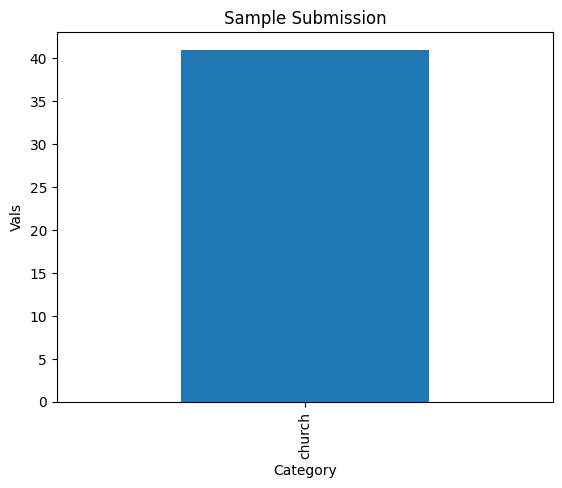

In [ ]:
# Plotting
# 1. sample_submission.csv
sample_submission['dataset'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Vals')
plt.title('Sample Submission')
plt.show()

In [ ]:
# Check for missing values in the three datasets
print("Missing values in Sample-Submission:", sample_submission.isnull().sum())

print("Missing values in Train-labels:", train_labels.isnull().sum())

print("Missing values in Categories:", categories.isnull().sum())

Missing values in Sample-Submission: image_path            0
dataset               0
scene                 0
rotation_matrix       0
translation_vector    0
dtype: int64
Missing values in Train-labels: image_name            0
rotation_matrix       0
translation_vector    0
calibration_matrix    0
dataset               0
scene                 0
dtype: int64
Missing values in Categories: scene         0
categories    0
dtype: int64


In [ ]:
# Check for duplicated values in the three datasets
print("Duplicates in Sample-Submission:", sample_submission.duplicated().any())

print("Duplicates in Train-labels:", train_labels.duplicated().any())

print("Duplicates in Categories:", categories.duplicated().any())

Duplicates in Sample-Submission: False
Duplicates in Train-labels: False
Duplicates in Categories: False


In [ ]:
# Path to the train and test directories
train_dir = '/kaggle/input/image-matching-challenge-2024/train'
test_dir = '/kaggle/input/image-matching-challenge-2024/test'

In [ ]:
# Path for the training images and testing
train_images = tf.data.Dataset.list_files(train_dir + '/*')
test_images = tf.data.Dataset.list_files(test_dir + '/*')

In [ ]:
# Filtering the training and testing images to exclude .csv
train_images = train_images.filter(lambda x: not tf.strings.regex_full_match(x, '.*\.csv'))
test_images = test_images.filter(lambda x: not tf.strings.regex_full_match(x, '.*\.csv'))

In [ ]:
for file_path in train_images:
    print(file_path.numpy())

b'/kaggle/input/image-matching-challenge-2024/train/multi-temporal-temple-baalshamin'
b'/kaggle/input/image-matching-challenge-2024/train/church'
b'/kaggle/input/image-matching-challenge-2024/train/transp_obj_glass_cylinder'
b'/kaggle/input/image-matching-challenge-2024/train/lizard'
b'/kaggle/input/image-matching-challenge-2024/train/transp_obj_glass_cup'
b'/kaggle/input/image-matching-challenge-2024/train/pond'
b'/kaggle/input/image-matching-challenge-2024/train/dioscuri'


In [ ]:
for file_path in test_images:
    print(file_path.numpy())

b'/kaggle/input/image-matching-challenge-2024/test/church'


In [ ]:
# Shuffing
train_images = train_images.shuffle(500)
test_images = test_images.shuffle(500)

In [ ]:
for file_path in train_images:
    print(file_path.numpy())

b'/kaggle/input/image-matching-challenge-2024/train/lizard'
b'/kaggle/input/image-matching-challenge-2024/train/multi-temporal-temple-baalshamin'
b'/kaggle/input/image-matching-challenge-2024/train/transp_obj_glass_cylinder'
b'/kaggle/input/image-matching-challenge-2024/train/transp_obj_glass_cup'
b'/kaggle/input/image-matching-challenge-2024/train/church'
b'/kaggle/input/image-matching-challenge-2024/train/dioscuri'
b'/kaggle/input/image-matching-challenge-2024/train/pond'


In [ ]:
# Classes in our dataset both of training and testing
train_classes = ["church", "dioscuri", "lizard", "multi-temporal-temple-baalshar", "pond", "transp_obj_glass_cup", "transp_obj_glass_cylinder"]
test_classes = ["church"]

In [ ]:
# Finding the count of classes for training
train_images_count = 0
for _ in train_images:
    train_images_count += 1

print(train_images_count)

7


In [ ]:
# Finding the count of classes for testing
test_images_count = 0
for _ in test_images:
    test_images_count += 1

print(test_images_count)

1


In [ ]:
train_size = int(train_images_count + test_images_count * 0.8)

train_ds = train_images.take(train_size)
test_ds = train_images.skip(train_size)

In [ ]:
def get_label(file_path):
    return tf.strings.split(file_path, os.path.sep)[-2]

In [ ]:
def process_image(file_path):
    label = get_label(file_path)

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])

    return img, label

In [ ]:
for t in train_ds.take(4):
    print (t.numpy())

b'/kaggle/input/image-matching-challenge-2024/train/church'
b'/kaggle/input/image-matching-challenge-2024/train/dioscuri'
b'/kaggle/input/image-matching-challenge-2024/train/lizard'
b'/kaggle/input/image-matching-challenge-2024/train/transp_obj_glass_cup'


In [ ]:
import matplotlib.image as mpimg

In [ ]:
def process_image(file_path, label):

    img = tf.io.read_file(file_path)

    img = tf.image.decode_jpeg(img, channels=3)  # Adjust channels if needed

    img = tf.image.resize(img, [img_height, img_width])

    img = img / 255.0
    return img, label

# **Showing Random Images from Directory (Train and Test)**

# **Loading Images from Train directory**

You can show random images by applying the code below from the training directory with matplotlib or seaborn.

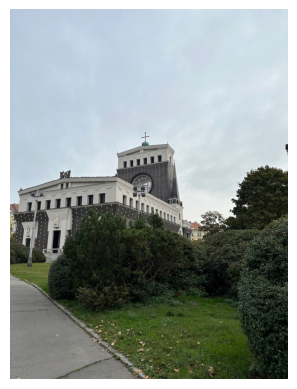

In [ ]:
image_path = "/kaggle/input/image-matching-challenge-2024/train/church/images/00004.png"

# Load the image
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

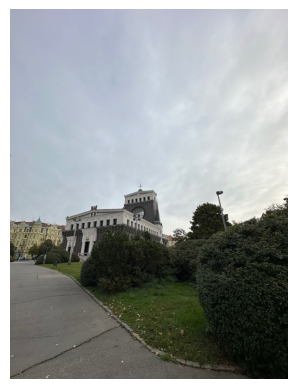

In [ ]:
image_path = "/kaggle/input/image-matching-challenge-2024/train/church/images/00005.png"

# Load the image
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

# **Loading Images from Test directory**

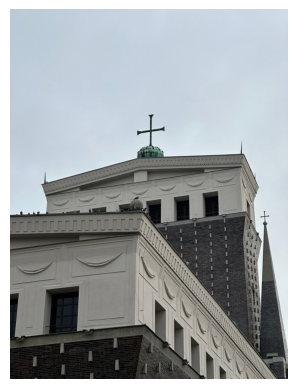

In [ ]:
image_path = "/kaggle/input/image-matching-challenge-2024/test/church/images/00018.png"

# Load the image
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

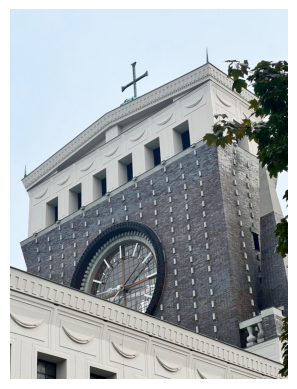

In [ ]:
image_path = "/kaggle/input/image-matching-challenge-2024/test/church/images/00026.png"

# Load the image
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

# **Applying Prefetch and Cache for performance enhancement**

# 1. **Prefetch**

You can add prefetch with buffer_size=1 and buffer_size=2 and even buffer_size=tf.data.experimental.AUTOTUNE, with applying these buffer sizes, your time can change and performance can maybe decrease or increase.

In [ ]:
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    return img, label

In [ ]:
train_ds = train_images.take(train_size).map(lambda x: process_image(x, get_label(x)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = train_images.skip(train_size).map(lambda x: process_image(x, get_label(x)), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Before prefetching
start_time = time.time()

# Define and preprocess the dataset without prefetching
train_ds = train_images.take(train_size).map(lambda x: process_image(x, get_label(x)))

In [ ]:
# Apply prefetching
train_ds = train_ds.prefetch(buffer_size=1)

# Calculate time taken
time_after_prefetch1 = time.time() - start_time

In [ ]:
print("Time taken after prefetching buffer_size 1:", time_after_prefetch1)

Time taken after prefetching buffer_size 1: 0.0792245864868164


In [ ]:
# Apply prefetching
train_ds = train_ds.prefetch(buffer_size=2)

# Calculate time taken
time_after_prefetch2 = time.time() - start_time

In [ ]:
print("Time taken after prefetching buffer size 2:", time_after_prefetch2)

Time taken after prefetching buffer size 2: 0.11469197273254395


In [ ]:
# Apply prefetching
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Calculate time taken
time_after_prefetch_AUTOTUNE = time.time() - start_time

In [ ]:
print("Time taken after prefetching buffer size AUTOTUNE:", time_after_prefetch_AUTOTUNE)

Time taken after prefetching buffer size AUTOTUNE: 0.1378612518310547


# 2. **Cache**

In [ ]:
# Before caching
start_time = time.time()

# Define and preprocess the dataset without prefetching and caching
train_ds_no_cache = train_images.take(train_size).map(lambda x: process_image(x, get_label(x)), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Calculate time taken
time_before_cache = time.time() - start_time

# Apply caching
train_ds_cached = train_ds_no_cache.cache()

In [ ]:
# Calculate time taken
time_after_cache = time.time() - start_time

In [ ]:
print("Time taken before caching:", time_before_cache)
print("Time taken after caching:", time_after_cache)

Time taken before caching: 0.06079864501953125
Time taken after caching: 0.07644486427307129
